# ML-Agents Q-Learning with GridWorld
<img src="https://github.com/Unity-Technologies/ml-agents/blob/release_21_docs/docs/images/gridworld.png?raw=true" align="middle" width="435"/>

## Setup

In [1]:
#@title Install Rendering Dependencies { display-mode: "form" }
#@markdown (You only need to run this code when using Colab's hosted runtime)

import os
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

pro_bar = display(progress(0, 100), display_id=True)

try:
  import google.colab
  INSTALL_XVFB = True
except ImportError:
  INSTALL_XVFB = 'COLAB_ALWAYS_INSTALL_XVFB' in os.environ

if INSTALL_XVFB:
  with open('frame-buffer', 'w') as writefile:
    writefile.write("""#taken from https://gist.github.com/jterrace/2911875
XVFB=/usr/bin/Xvfb
XVFBARGS=":1 -screen 0 1024x768x24 -ac +extension GLX +render -noreset"
PIDFILE=./frame-buffer.pid
case "$1" in
  start)
    echo -n "Starting virtual X frame buffer: Xvfb"
    /sbin/start-stop-daemon --start --quiet --pidfile $PIDFILE --make-pidfile --background --exec $XVFB -- $XVFBARGS
    echo "."
    ;;
  stop)
    echo -n "Stopping virtual X frame buffer: Xvfb"
    /sbin/start-stop-daemon --stop --quiet --pidfile $PIDFILE
    rm $PIDFILE
    echo "."
    ;;
  restart)
    $0 stop
    $0 start
    ;;
  *)
        echo "Usage: /etc/init.d/xvfb {start|stop|restart}"
        exit 1
esac
exit 0
    """)
  !sudo apt-get update
  pro_bar.update(progress(10, 100))
  !sudo DEBIAN_FRONTEND=noninteractive apt install -y daemon wget gdebi-core build-essential libfontenc1 libfreetype6 xorg-dev xorg
  pro_bar.update(progress(20, 100))
  !wget http://security.ubuntu.com/ubuntu/pool/main/libx/libxfont/libxfont1_1.5.1-1ubuntu0.16.04.4_amd64.deb 2>&1
  pro_bar.update(progress(30, 100))
  !wget --output-document xvfb.deb http://security.ubuntu.com/ubuntu/pool/universe/x/xorg-server/xvfb_1.18.4-0ubuntu0.12_amd64.deb 2>&1
  pro_bar.update(progress(40, 100))
  !sudo dpkg -i libxfont1_1.5.1-1ubuntu0.16.04.4_amd64.deb 2>&1
  pro_bar.update(progress(50, 100))
  !sudo dpkg -i xvfb.deb 2>&1
  pro_bar.update(progress(70, 100))
  !rm libxfont1_1.5.1-1ubuntu0.16.04.4_amd64.deb
  pro_bar.update(progress(80, 100))
  !rm xvfb.deb
  pro_bar.update(progress(90, 100))
  !bash frame-buffer start
  os.environ["DISPLAY"] = ":1"
pro_bar.update(progress(100, 100))

### Installing ml-agents

In [2]:
try:
  import mlagents
  print("ml-agents already installed")
except ImportError:
  !python -m pip install -q mlagents==1.0.0
  print("Installed ml-agents")

ml-agents already installed


## Train the GridWorld Environment with Q-Learning

### What is the GridWorld Environment

The [GridWorld](https://github.com/Unity-Technologies/ml-agents/blob/release_21_docs/docs/Learning-Environment-Examples.md#gridworld) Environment is a simple Unity visual environment. The Agent is a blue square in a 3x3 grid that is trying to reach a green __`+`__ while avoiding a red __`x`__.

The observation is an image obtained by a camera on top of the grid.

The Action can be one of 5 :
 - Do not move
 - Move up
 - Move down
 - Move right
 - Move left

The Agent receives a reward of _1.0_ if it reaches the green __`+`__, a penalty of _-1.0_ if it touches the red __`x`__ and a penalty of `-0.01` at every step (to force the Agent to solve the task as fast as possible)

__Note__ There are 9 Agents, each in their own grid, at once in the environment. This alows for faster data collection.




### The Q-Learning Algorithm


In [3]:
import torch
from typing import Tuple
from math import floor
from torch.nn import Parameter


class VisualQNetwork(torch.nn.Module):
  def __init__(
    self,
    input_shape: Tuple[int, int, int],
    encoding_size: int,
    output_size: int
  ):
    """
    Creates a neural network that takes as input a batch of images (3
    dimensional tensors) and outputs a batch of outputs (1 dimensional
    tensors)
    """
    super(VisualQNetwork, self).__init__()
    height = input_shape[1]
    width = input_shape[2]
    initial_channels = input_shape[0]
    conv_1_hw = self.conv_output_shape((height, width), 8, 4)
    conv_2_hw = self.conv_output_shape(conv_1_hw, 4, 2)
    self.final_flat = conv_2_hw[0] * conv_2_hw[1] * 32
    self.conv1 = torch.nn.Conv2d(initial_channels, 16, [8, 8], [4, 4])
    self.conv2 = torch.nn.Conv2d(16, 32, [4, 4], [2, 2])
    self.dense1 = torch.nn.Linear(self.final_flat, encoding_size)
    self.dense2 = torch.nn.Linear(encoding_size, output_size)

  def forward(self, visual_obs: torch.tensor):
    conv_1 = torch.relu(self.conv1(visual_obs))
    conv_2 = torch.relu(self.conv2(conv_1))
    hidden = self.dense1(conv_2.reshape([-1, self.final_flat]))
    hidden = torch.relu(hidden)
    hidden = self.dense2(hidden)
    return hidden

  @staticmethod
  def conv_output_shape(
    h_w: Tuple[int, int],
    kernel_size: int = 1,
    stride: int = 1,
    pad: int = 0,
    dilation: int = 1,
  ):
    """
    Computes the height and width of the output of a convolution layer.
    """
    h = floor(
      ((h_w[0] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
    )
    w = floor(
      ((h_w[1] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
    )
    return h, w


In this Notebook, we will implement a very simple Q-Learning algorithm. We will use [pytorch](https://pytorch.org/) to do so.

Below is the code to create the neural network we will use in the Notebook.

We will now create a few classes to help us store the data we will use to train the Q-Learning algorithm.

In [4]:
import numpy as np
from typing import NamedTuple, List


class Experience(NamedTuple):
  """
  An experience contains the data of one Agent transition.
  - Observation
  - Action
  - Reward
  - Done flag
  - Next Observation
  """

  obs: np.ndarray
  action: np.ndarray
  reward: float
  done: bool
  next_obs: np.ndarray

# A Trajectory is an ordered sequence of Experiences
Trajectory = List[Experience]

# A Buffer is an unordered list of Experiences from multiple Trajectories
Buffer = List[Experience]

Now, we can create our trainer class. The role of this trainer is to collect data from the Environment according to a Policy, and then train the Q-Network with that data.

In [5]:
from mlagents_envs.environment import ActionTuple, BaseEnv
from typing import Dict
import random


class Trainer:
  @staticmethod
  def generate_trajectories(
    env: BaseEnv, q_net: VisualQNetwork, buffer_size: int, epsilon: float
  ):
    """
    Given a Unity Environment and a Q-Network, this method will generate a
    buffer of Experiences obtained by running the Environment with the Policy
    derived from the Q-Network.
    :param BaseEnv: The UnityEnvironment used.
    :param q_net: The Q-Network used to collect the data.
    :param buffer_size: The minimum size of the buffer this method will return.
    :param epsilon: Will add a random normal variable with standard deviation.
    epsilon to the value heads of the Q-Network to encourage exploration.
    :returns: a Tuple containing the created buffer and the average cumulative
    the Agents obtained.
    """
    # Create an empty Buffer
    buffer: Buffer = []

    # Reset the environment
    env.reset()
    # Read and store the Behavior Name of the Environment
    behavior_name = list(env.behavior_specs)[0]
    # Read and store the Behavior Specs of the Environment
    spec = env.behavior_specs[behavior_name]

    # Create a Mapping from AgentId to Trajectories. This will help us create
    # trajectories for each Agents
    dict_trajectories_from_agent: Dict[int, Trajectory] = {}
    # Create a Mapping from AgentId to the last observation of the Agent
    dict_last_obs_from_agent: Dict[int, np.ndarray] = {}
    # Create a Mapping from AgentId to the last observation of the Agent
    dict_last_action_from_agent: Dict[int, np.ndarray] = {}
    # Create a Mapping from AgentId to cumulative reward (Only for reporting)
    dict_cumulative_reward_from_agent: Dict[int, float] = {}
    # Create a list to store the cumulative rewards obtained so far
    cumulative_rewards: List[float] = []

    while len(buffer) < buffer_size:  # While not enough data in the buffer
      # Get the Decision Steps and Terminal Steps of the Agents
      decision_steps, terminal_steps = env.get_steps(behavior_name)

      # permute the tensor to go from NHWC to NCHW
      # order = (0, 3, 1, 2)
      # decision_steps.obs = [np.transpose(obs, order) for obs in decision_steps.obs]
      # terminal_steps.obs = [np.transpose(obs, order) for obs in terminal_steps.obs]

      # For all Agents with a Terminal Step:
      for agent_id_terminated in terminal_steps:
        # Create its last experience (is last because the Agent terminated)
        last_experience = Experience(
          obs=dict_last_obs_from_agent[agent_id_terminated].copy(),
          reward=terminal_steps[agent_id_terminated].reward,
          done=not terminal_steps[agent_id_terminated].interrupted,
          action=dict_last_action_from_agent[agent_id_terminated].copy(),
          next_obs=terminal_steps[agent_id_terminated].obs[0],
        )
        # Clear its last observation and action (Since the trajectory is over)
        dict_last_obs_from_agent.pop(agent_id_terminated)
        dict_last_action_from_agent.pop(agent_id_terminated)
        # Report the cumulative reward
        cumulative_reward = (
          dict_cumulative_reward_from_agent.pop(agent_id_terminated)
          + terminal_steps[agent_id_terminated].reward
        )
        cumulative_rewards.append(cumulative_reward)
        # Add the Trajectory and the last experience to the buffer
        buffer.extend(dict_trajectories_from_agent.pop(agent_id_terminated))
        buffer.append(last_experience)

      # For all Agents with a Decision Step:
      for agent_id_decisions in decision_steps:
        # If the Agent does not have a Trajectory, create an empty one
        if agent_id_decisions not in dict_trajectories_from_agent:
          dict_trajectories_from_agent[agent_id_decisions] = []
          dict_cumulative_reward_from_agent[agent_id_decisions] = 0

        # If the Agent requesting a decision has a "last observation"
        if agent_id_decisions in dict_last_obs_from_agent:
          # Create an Experience from the last observation and the Decision Step
          exp = Experience(
            obs=dict_last_obs_from_agent[agent_id_decisions].copy(),
            reward=decision_steps[agent_id_decisions].reward,
            done=False,
            action=dict_last_action_from_agent[agent_id_decisions].copy(),
            next_obs=decision_steps[agent_id_decisions].obs[0],
          )
          # Update the Trajectory of the Agent and its cumulative reward
          dict_trajectories_from_agent[agent_id_decisions].append(exp)
          dict_cumulative_reward_from_agent[agent_id_decisions] += (
            decision_steps[agent_id_decisions].reward
          )
        # Store the observation as the new "last observation"
        dict_last_obs_from_agent[agent_id_decisions] = (
          decision_steps[agent_id_decisions].obs[0]
        )

      # Generate an action for all the Agents that requested a decision
      # Compute the values for each action given the observation
      actions_values = (
        q_net(torch.from_numpy(decision_steps.obs[0])).detach().numpy()
      )
      # Add some noise with epsilon to the values
      actions_values += epsilon * (
        np.random.randn(actions_values.shape[0], actions_values.shape[1])
      ).astype(np.float32)
      # Pick the best action using argmax
      actions = np.argmax(actions_values, axis=1)
      actions.resize((len(decision_steps), 1))
      # Store the action that was picked, it will be put in the trajectory later
      for agent_index, agent_id in enumerate(decision_steps.agent_id):
        dict_last_action_from_agent[agent_id] = actions[agent_index]

      # Set the actions in the environment
      # Unity Environments expect ActionTuple instances.
      action_tuple = ActionTuple()
      action_tuple.add_discrete(actions)
      env.set_actions(behavior_name, action_tuple)
      # Perform a step in the simulation
      env.step()
    return buffer, np.mean(cumulative_rewards)

  @staticmethod
  def update_q_net(
    q_net: VisualQNetwork,
    optimizer: torch.optim,
    buffer: Buffer,
    action_size: int
  ):
    """
    Performs an update of the Q-Network using the provided optimizer and buffer
    """
    BATCH_SIZE = 1000
    NUM_EPOCH = 3
    GAMMA = 0.9
    batch_size = min(len(buffer), BATCH_SIZE)
    random.shuffle(buffer)
    # Split the buffer into batches
    batches = [
      buffer[batch_size * start : batch_size * (start + 1)]
      for start in range(int(len(buffer) / batch_size))
    ]
    for _ in range(NUM_EPOCH):
      for batch in batches:
        # Create the Tensors that will be fed in the network
        obs = torch.from_numpy(np.stack([ex.obs for ex in batch]))
        reward = torch.from_numpy(
          np.array([ex.reward for ex in batch], dtype=np.float32).reshape(-1, 1)
        )
        done = torch.from_numpy(
          np.array([ex.done for ex in batch], dtype=np.float32).reshape(-1, 1)
        )
        action = torch.from_numpy(np.stack([ex.action for ex in batch]))
        next_obs = torch.from_numpy(np.stack([ex.next_obs for ex in batch]))

        # Use the Bellman equation to update the Q-Network
        target = (
          reward
          + (1.0 - done)
          * GAMMA
          * torch.max(q_net(next_obs).detach(), dim=1, keepdim=True).values
        )
        mask = torch.zeros((len(batch), action_size))
        mask.scatter_(1, action, 1)
        prediction = torch.sum(q_net(obs) * mask, dim=1, keepdim=True)
        criterion = torch.nn.MSELoss()
        loss = criterion(prediction, target)

        # Perform the backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


### Run Training

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

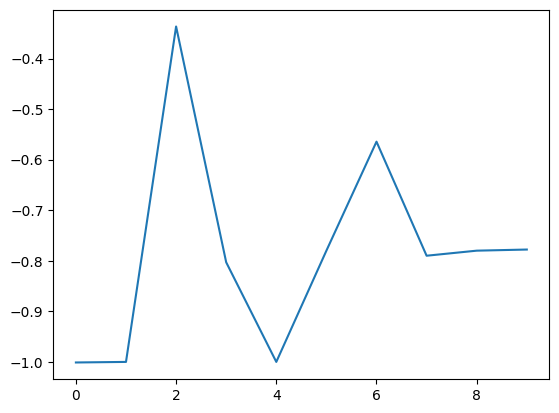

In [6]:
# -----------------
# This code is used to close an env that might not have been closed before
try:
  env.close()
except:
  pass
# -----------------

from mlagents_envs.registry import default_registry
from mlagents_envs.environment import UnityEnvironment
import matplotlib.pyplot as plt
import os
%matplotlib inline

# Create the GridWorld Environment from the registry
env = default_registry["GridWorld"].make()
print("GridWorld environment created.")

num_actions = 5

try:
  # Create a new Q-Network.
  qnet = VisualQNetwork((3, 64, 84), 126, num_actions)

  experiences: Buffer = []
  optim = torch.optim.Adam(qnet.parameters(), lr= 0.001)

  cumulative_rewards: List[float] = []

  # The number of training steps that will be performed
  NUM_TRAINING_STEPS = int(os.getenv('QLEARNING_NUM_TRAINING_STEPS', 10))
  # The number of experiences to collect per training step
  NUM_NEW_EXP = int(os.getenv('QLEARNING_NUM_NEW_EXP', 1000))
  # The maximum size of the Buffer
  BUFFER_SIZE = int(os.getenv('QLEARNING_BUFFER_SIZE', 10000))

  for n in range(NUM_TRAINING_STEPS):
    new_exp,_ = Trainer.generate_trajectories(env, qnet, NUM_NEW_EXP, epsilon=0.1)
    random.shuffle(experiences)
    if len(experiences) > BUFFER_SIZE:
      experiences = experiences[:BUFFER_SIZE]
    experiences.extend(new_exp)
    Trainer.update_q_net(qnet, optim, experiences, num_actions)
    _, rewards = Trainer.generate_trajectories(env, qnet, 100, epsilon=0)
    cumulative_rewards.append(rewards)
    print("Training step ", n+1, "\treward ", rewards)
except KeyboardInterrupt:
  print("\nTraining interrupted, continue to next cell to save to save the model.")
finally:
  env.close()

# Show the training graph
try:
  plt.plot(range(NUM_TRAINING_STEPS), cumulative_rewards)
except ValueError:
  print("\nPlot failed on interrupted training.")


### Export PyTorch Model to ONNX

The following cell provides an example of some of the extra tensors a model needs to work for ML-Agents inference with Sentis. The GridWorldColab scene is configured to work with this ONNX file.
Only policy models need to be exported for inference and they need the following additional tensors:

*   All models need version_number
*   All models need memory_size
*   Models with continuous outputs need continuous_action_output_shape
*   Models with discrete outputs need discrete_action_output_shape and an additional mask input that matches the shape of the discrete outputs
*   The mask input must be connected to the outputs or it will be pruned on export, if mask values aren't being set they will be 1, so multiplying the discrete outputs by the mask will have no effect

In [7]:
class WrapperNet(torch.nn.Module):
    def __init__(
            self,
            qnet: VisualQNetwork,
            discrete_output_sizes: List[int],
    ):
        """
        Wraps the VisualQNetwork adding extra constants and dummy mask inputs
        required by runtime inference with Sentis.

        For environment continuous actions outputs would need to add them
        similarly to how discrete action outputs work, both in the wrapper
        and in the ONNX output_names / dynamic_axes.
        """
        super(WrapperNet, self).__init__()
        self.qnet = qnet

        # version_number
        #   MLAgents1_0 = 2   (not covered by this example)
        #   MLAgents2_0 = 3
        version_number = torch.Tensor([3])
        self.version_number = Parameter(version_number, requires_grad=False)

        # memory_size
        # TODO: document case where memory is not zero.
        memory_size = torch.Tensor([0])
        self.memory_size = Parameter(memory_size, requires_grad=False)

        # discrete_action_output_shape
        output_shape=torch.Tensor([discrete_output_sizes])
        self.discrete_shape = Parameter(output_shape, requires_grad=False)


    # if you have discrete actions ML-agents expects corresponding a mask
    # tensor with the same shape to exist as input
    def forward(self, visual_obs: torch.tensor, mask: torch.tensor):
        qnet_result = self.qnet(visual_obs)
        # Connect mask to keep it from getting pruned
        # Mask values will be 1 if you never call SetActionMask() in
        # WriteDiscreteActionMask()
        qnet_result = torch.mul(qnet_result, mask)
        action = torch.argmax(qnet_result, dim=1, keepdim=True)
        return [action], self.discrete_shape, self.version_number, self.memory_size


torch.onnx.export(
    WrapperNet(qnet, [num_actions]),
    # A tuple with an example of the input tensors
    (torch.tensor([experiences[0].obs]), torch.ones(1, num_actions)),
    'GridWorldColab.onnx',
    opset_version=9,
    # input_names must correspond to the WrapperNet forward parameters
    # obs will be obs_0, obs_1, etc.
    input_names=["obs_0", "action_masks"],
    # output_names must correspond to the return tuple of the WrapperNet
    # forward function.
    output_names=["discrete_actions", "discrete_action_output_shape",
                  "version_number", "memory_size"],
    # All inputs and outputs should have their 0th dimension be designated
    # as 'batch'
    dynamic_axes={'obs_0': {0: 'batch'},
                  'action_masks': {0: 'batch'},
                  'discrete_actions': {0: 'batch'},
                  'discrete_action_output_shape': {0: 'batch'}
                 }
    )


/tmp/ipykernel_174482/2956909052.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  (torch.tensor([experiences[0].obs]), torch.ones(1, num_actions)),
